In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier  # Or LightGBM, CatBoost
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import zipfile
import re
import sqlite3
from sqlalchemy import create_engine

# Create a SQLite database engine
database_name = "march_madness.sqlite"
engine = create_engine(f'sqlite:///{database_name}')

dataset_name = "march-machine-learning-mania-2025"
dataframes = {}
zip_filename = dataset_name + '.zip'

try:
    with zipfile.ZipFile(zip_filename, 'r') as zip_file:
        print("Files in the ZIP:", zip_file.namelist())
        
        for filename in zip_file.namelist():
            if filename.endswith('.csv'):
                # Create a clean table name
                table_name = filename.replace('.csv', '').replace(' _ ', '_').replace(' ', '_')
                table_name = re.sub(r'[^a-zA-Z0-9_]', '', table_name)  # Remove any special characters
                
                try:
                    # Special handling for TeamSpellings files
                    if 'TeamSpellings' in filename:
                        df = pd.read_csv(
                            zip_file.open(filename), 
                            encoding='latin1',
                            low_memory=False
                        )
                    else:
                        # Default UTF-8 encoding for other files
                        df = pd.read_csv(
                            zip_file.open(filename), 
                            low_memory=False
                        )
                    
                    # Write the dataframe to SQLite database
                    df.to_sql(table_name, engine, if_exists='replace', index=False)
                    print(f"Loaded and converted to SQL: {filename} -> {table_name}")
                    
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
                    
except FileNotFoundError:
    print(f"Could not find the zip file: {zip_filename}")
except zipfile.BadZipFile:
    print(f"The file {zip_filename} is not a valid zip file")
except Exception as e:
    print(f"An error occurred: {str(e)}")

# Example of how to query the database and convert to pandas dataframe
def query_to_dataframe(query):
    """
    Execute a SQL query and return the results as a pandas DataFrame
    """
    try:
        return pd.read_sql_query(query, engine)
    except Exception as e:
        print(f"Error executing query: {str(e)}")
        return None

# Example usage:
# df = query_to_dataframe("SELECT * FROM TableName LIMIT 5")


Files in the ZIP: ['Cities.csv', 'Conferences.csv', 'MConferenceTourneyGames.csv', 'MGameCities.csv', 'MMasseyOrdinals.csv', 'MNCAATourneyCompactResults.csv', 'MNCAATourneyDetailedResults.csv', 'MNCAATourneySeedRoundSlots.csv', 'MNCAATourneySeeds.csv', 'MNCAATourneySlots.csv', 'MRegularSeasonCompactResults.csv', 'MRegularSeasonDetailedResults.csv', 'MSeasons.csv', 'MSecondaryTourneyCompactResults.csv', 'MSecondaryTourneyTeams.csv', 'MTeamCoaches.csv', 'MTeamConferences.csv', 'MTeamSpellings.csv', 'MTeams.csv', 'SampleSubmissionStage1.csv', 'SampleSubmissionStage2.csv', 'SeedBenchmarkStage1.csv', 'WConferenceTourneyGames.csv', 'WGameCities.csv', 'WNCAATourneyCompactResults.csv', 'WNCAATourneyDetailedResults.csv', 'WNCAATourneySeeds.csv', 'WNCAATourneySlots.csv', 'WRegularSeasonCompactResults.csv', 'WRegularSeasonDetailedResults.csv', 'WSeasons.csv', 'WSecondaryTourneyCompactResults.csv', 'WSecondaryTourneyTeams.csv', 'WTeamConferences.csv', 'WTeamSpellings.csv', 'WTeams.csv']
Loaded and

# Submission Format

In [4]:
# Show all columns
pd.set_option('display.max_columns', None)

query = """
select 
*
from WNCAATourneySeeds

UNION ALL

select
*
from MNCAATourneySeeds
"""
seed_df = query_to_dataframe(query)
seed_df.head()


,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272


In [5]:
query = """
select 
*
from SampleSubmissionStage2
"""
submission_df = query_to_dataframe(query)
submission_df.head()

,ID,Pred
0,2025_1101_1102,0.5
1,2025_1101_1103,0.5
2,2025_1101_1104,0.5
3,2025_1101_1105,0.5
4,2025_1101_1106,0.5


In [6]:
def extract_game_info(id_str):
    # Extract year and team_ids
    parts = id_str.split('_')
    year = int(parts[0])
    teamID1 = int(parts[1])
    teamID2 = int(parts[2])
    return year, teamID1, teamID2

def extract_seed_value(seed_str):
    # Extract seed value
    try:
        return int(seed_str[1:])
    # Set seed to 16 for unselected teams and errors
    except ValueError:
        return 16

# Reformat the data
submission_df[['Season', 'TeamID1', 'TeamID2']] = submission_df['ID'].apply(extract_game_info).tolist()
seed_df['SeedValue'] = seed_df['Seed'].apply(extract_seed_value)

# Merge seed information for TeamID1
submission_df = pd.merge(submission_df, seed_df[['Season', 'TeamID', 'SeedValue']],
                         left_on=['Season', 'TeamID1'], right_on=['Season', 'TeamID'],
                         how='left')
submission_df = submission_df.rename(columns={'SeedValue': 'SeedValue1'}).drop(columns=['TeamID'])

# Merge seed information for TeamID2
submission_df = pd.merge(submission_df, seed_df[['Season', 'TeamID', 'SeedValue']],
                         left_on=['Season', 'TeamID2'], right_on=['Season', 'TeamID'],
                         how='left')
submission_df = submission_df.rename(columns={'SeedValue': 'SeedValue2'}).drop(columns=['TeamID'])
submission_df.head()

,ID,Pred,Season,TeamID1,TeamID2,SeedValue1,SeedValue2
0,2025_1101_1102,0.5,2025,1101,1102,NaN,NaN
1,2025_1101_1103,0.5,2025,1101,1103,NaN,NaN
2,2025_1101_1104,0.5,2025,1101,1104,NaN,NaN
3,2025_1101_1105,0.5,2025,1101,1105,NaN,NaN
4,2025_1101_1106,0.5,2025,1101,1106,NaN,NaN


In [7]:
# Calculate seed difference
submission_df['SeedDiff'] = submission_df['SeedValue1'] - submission_df['SeedValue2']

# Update 'Pred' column
submission_df['Pred'] = 0.5 + (0.03 * submission_df['SeedDiff'])

# Drop unnecessary columns
submission_df = submission_df[['ID', 'Pred']].fillna(0.5)

# Preview your submission 
submission_df.head()

,ID,Pred
0,2025_1101_1102,0.5
1,2025_1101_1103,0.5
2,2025_1101_1104,0.5
3,2025_1101_1105,0.5
4,2025_1101_1106,0.5


In [8]:
submission_df.to_csv('submission.csv', index=False)

# Feature Selection

As with prior years, each game has a unique ID created by concatenating the season in which the game was played and the two team's respective TeamIds. For example, "2025_1101_1102" indicates a hypothetical matchup between team 1101 and 1102 in the year 2025. You must predict the probability that the team with the lower TeamId beats the team with the higher TeamId. Note that the men's teams and women's TeamIds do not overlap.


In [63]:
# Show all columns
pd.set_option('display.max_columns', None)

query = """
select * from WRegularSeasonDetailedResults

UNION ALL
select * from MRegularSeasonDetailedResults



--Limit 5
"""
data = pd.read_sql_query(query,engine)
data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,H,0,23,54,5,9,12,19,10,26,14,18,7,0,15,20,54,3,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,5,12,16,28,16,31,15,20,5,2,25,25,63,4,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,6,15,7,12,14,23,18,13,6,2,17,19,58,2,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,A,0,27,52,4,11,5,9,6,40,14,27,5,10,18,18,74,6,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,H,1,30,74,7,20,7,11,14,33,18,11,5,3,18,25,74,9,17,11,21,21,32,12,14,4,2,14


In [10]:

table_name ='AllRegularSeasonResults'
data.to_sql(table_name, engine, if_exists='replace', index=False)



198374

In [50]:
# Show all columns
pd.set_option('display.max_columns', None)

query = """
select
Season + 1 as prediction_year,
Wteamid,
avg(WFGM - LFGM) as average_score_difference,
avg(WFGM3) as average_3_pointers,
avg(WFGA3) as average_3_pointers_attempted,
avg(WFGM3)/avg(WFGA3) as average_3_point_accuracy,

avg(WOR) as average_offensive_rebound,
avg(WDR) as average_defensive_rebound


from AllRegularSeasonResults
group by 1,2

"""
df = pd.read_sql_query(query,engine)
df.head()

,prediction_year,WTeamID,average_score_difference,average_3_pointers,average_3_pointers_attempted,average_3_point_accuracy,average_offensive_rebound,average_defensive_rebound
0,2004,1102,3.583333,10.000000,21.583333,0.463320,3.833333,19.333333
1,2004,1103,2.461538,5.461538,14.384615,0.379679,9.384615,21.461538
2,2004,1104,3.705882,7.058824,20.823529,0.338983,13.529412,26.411765
3,2004,1105,2.571429,9.142857,22.428571,0.407643,14.571429,25.857143
4,2004,1106,6.000000,5.846154,15.923077,0.367150,12.769231,28.000000


In [49]:
query = """
select
R.season,
R.wteamid,
1 as target,
R.lteamid

from AllRegularSeasonResults R



limit 5

"""
pd.read_sql_query(query,engine)

,Season,WTeamID,target,LTeamID
0,2010,3103,1,3237
1,2010,3104,1,3399
2,2010,3110,1,3224
3,2010,3111,1,3267
4,2010,3119,1,3447


In [69]:
from sqlalchemy import text

query = """
SELECT
    R.season,
    R.wteamid,
    1 AS target,
    R.lteamid,
    WTeam.average_score_difference AS WWASD,
    WTeam.average_3_pointers AS WA3P,
    WTeam.average_3_pointers_attempted AS WA3PA,
    WTeam.average_3_point_accuracy AS WA3PAP,
    WTeam.average_offensive_rebound AS WAOR,
    WTeam.average_defensive_rebound AS WADR,

    LTeam.average_score_difference AS LWASD,
    LTeam.average_3_pointers AS LA3P,
    LTeam.average_3_pointers_attempted AS LA3PA,
    LTeam.average_3_point_accuracy AS LA3PAP,
    LTeam.average_offensive_rebound AS LAOR,
    LTeam.average_defensive_rebound AS LADR
FROM 
    AllRegularSeasonResults R
INNER JOIN
    (SELECT
         Season + 1 AS prediction_year,
         Wteamid,
         AVG(WFGM - LFGM) AS average_score_difference,
         AVG(WFGM3) AS average_3_pointers,
         AVG(WFGA3) AS average_3_pointers_attempted,
         AVG(WFGM3) / NULLIF(AVG(WFGA3), 0) AS average_3_point_accuracy,
         AVG(WOR) AS average_offensive_rebound,
         AVG(WDR) AS average_defensive_rebound
     FROM 
         AllRegularSeasonResults
     GROUP BY 
         Season + 1, Wteamid) WTeam
ON 
    WTeam.prediction_year = R.Season
AND 
    WTeam.Wteamid = R.WTeamID

INNER JOIN
    (SELECT
         Season + 1 AS prediction_year,
         Wteamid,
         AVG(WFGM - LFGM) AS average_score_difference,
         AVG(WFGM3) AS average_3_pointers,
         AVG(WFGA3) AS average_3_pointers_attempted,
         AVG(WFGM3) / NULLIF(AVG(WFGA3), 0) AS average_3_point_accuracy,
         AVG(WOR) AS average_offensive_rebound,
         AVG(WDR) AS average_defensive_rebound
     FROM 
         AllRegularSeasonResults
     GROUP BY 
         Season + 1, Wteamid) LTeam
ON 
    LTeam.prediction_year = R.Season
AND 
    LTeam.Wteamid = R.LTeamID

"""

# Execute using SQLAlchemy
with engine.connect() as connection:
    result = connection.execute(text(query))
    df = pd.DataFrame(result.fetchall(), columns=result.keys())

df.head()

,Season,WTeamID,target,LTeamID,WWASD,WA3P,WA3PA,WA3PAP,WAOR,WADR,LWASD,LA3P,LA3PA,LA3PAP,LAOR,LADR
0,2004,1102,1,1115,3.583333,10.0,21.583333,0.46332,3.833333,19.333333,3.500000,5.500000,17.250000,0.318841,9.750000,23.500000
1,2004,1102,1,1140,3.583333,10.0,21.583333,0.46332,3.833333,19.333333,5.086957,6.478261,15.565217,0.416201,10.217391,25.000000
2,2004,1102,1,1143,3.583333,10.0,21.583333,0.46332,3.833333,19.333333,3.142857,6.047619,15.761905,0.383686,10.476190,25.904762
3,2004,1102,1,1149,3.583333,10.0,21.583333,0.46332,3.833333,19.333333,4.333333,3.416667,11.916667,0.286713,10.416667,21.750000
4,2004,1102,1,1161,3.583333,10.0,21.583333,0.46332,3.833333,19.333333,2.882353,4.000000,10.352941,0.386364,11.176471,25.823529


In [72]:
def prepare_data(df):
    games = df
    games['WTeamWon'] = 1
    games_reversed = games[games.WTeamID < games.LTeamID].copy()
    games_reversed[['WTeamID', 'LTeamID']] = games_reversed[['LTeamID', 'WTeamID']]
    games_reversed['WTeamWon'] = 0
    games = pd.concat((games, games_reversed), ignore_index=True)
    games['ID'] = games.apply(lambda r: '_'.join(map(str, [r['Season'], r['WTeamID'], r['LTeamID']])), axis=1)
    return games

df = prepare_data(df)

# Model Training

In [73]:
df.tail()

,Season,WTeamID,target,LTeamID,WWASD,WA3P,WA3PA,WA3PAP,WAOR,WADR,LWASD,LA3P,LA3PA,LA3PAP,LAOR,LADR,WTeamWon,ID
277728,2025,3468,1,3466,1.800000,8.400000,23.200000,0.362069,6.20,25.200000,1.125000,5.375000,19.875000,0.270440,11.250000,23.125000,0,2025.0_3468.0_3466.0
277729,2025,3474,1,3466,1.800000,8.400000,23.200000,0.362069,6.20,25.200000,4.250000,4.500000,16.000000,0.281250,9.250000,24.750000,0,2025.0_3474.0_3466.0
277730,2025,3474,1,3468,1.125000,5.375000,19.875000,0.270440,11.25,23.125000,4.250000,4.500000,16.000000,0.281250,9.250000,24.750000,0,2025.0_3474.0_3468.0
277731,2025,3475,1,3473,3.833333,5.500000,19.333333,0.284483,9.00,18.833333,6.409091,7.727273,20.318182,0.380313,9.500000,28.181818,0,2025.0_3475.0_3473.0
277732,2025,3478,1,3475,6.409091,7.727273,20.318182,0.380313,9.50,28.181818,4.500000,5.111111,15.611111,0.327402,11.111111,23.388889,0,2025.0_3478.0_3475.0


In [74]:
features = ["WWASD", "WA3P", "WA3PA", "WA3PAP", "WAOR", "WADR", "LWASD", "LA3P", "LA3PA", "LA3PAP", "LAOR", "LADR"]
target = 'WTeamWon'

# Drop rows with NaN values
games = df.dropna(subset=features + [target])

x = games[features]
y = games[target]



In [75]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model_m = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')  # Added random_state for reproducibility, address deprecation warning
model_m.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Brier Score: 0.22142675111725224


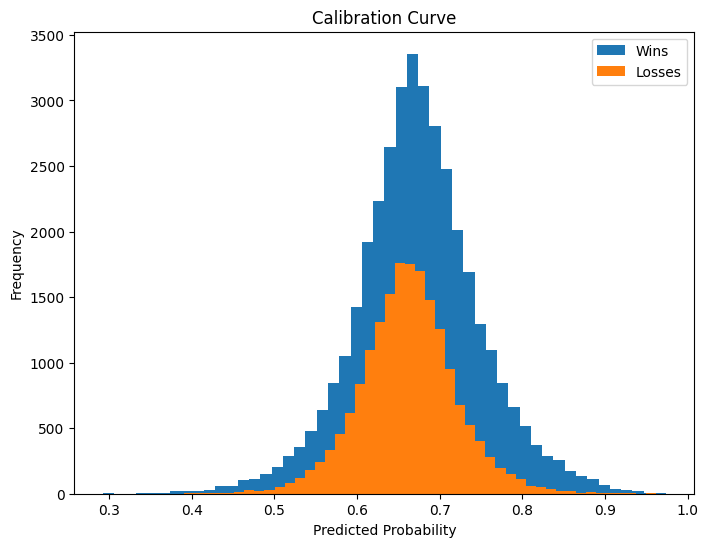

In [77]:
preds_m = model_m.predict_proba(X_test)[:, 1]
brier_score_m = brier_score_loss(y_test, preds_m)
print(f'Brier Score: {brier_score_m}')

# --- Visualization ---

def plot_calibration_curve(y_true, y_prob, title='Calibration Curve'):
    plt.figure(figsize=(8, 6))
    plt.hist(y_prob[y_true == 1], bins=50, label='Wins')
    plt.hist(y_prob[y_true == 0], bins=50, label='Losses')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()

plot_calibration_curve(y_test, preds_m, title='Calibration Curve')


# Submission